In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stock = '9064'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1)]

In [3]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

## Visualization

What do I want to say here?

* that data is quite random
* distribution of queue imbalance
* that there is some correlation between queue imbalance and mid price indicator 
* show some gdf values

In [4]:
df = gdf_dfs[2].df

### Mid Price

Data is quite random, there are outliers

Text(0.5,1,'Mid-Price for 9064 for training dataset')

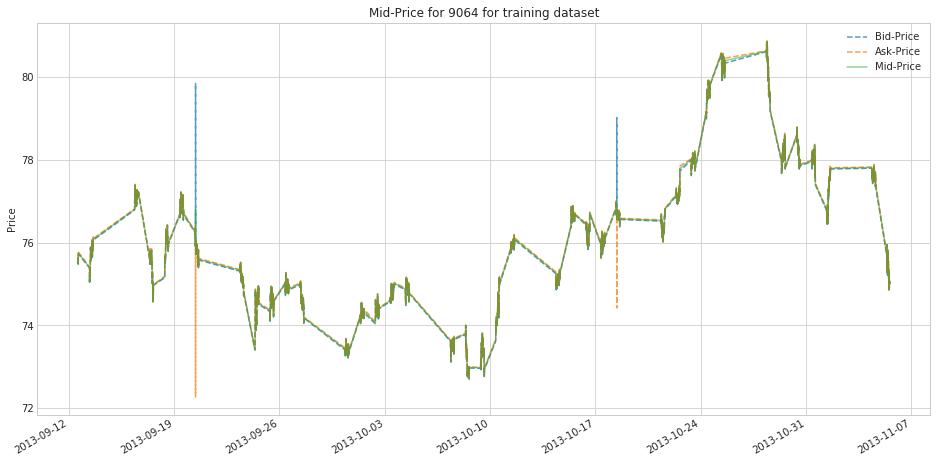

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

df[['bid_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].plot(ax=ax, alpha=0.5)
plt.legend(['Bid-Price', 'Ask-Price', 'Mid-Price',])
plt.ylabel('Price')
plt.xlabel('')
plt.title('Mid-Price for {} for training dataset'.format(stock))

We can observe outliers, lets look into them - both are around 11 Fridays

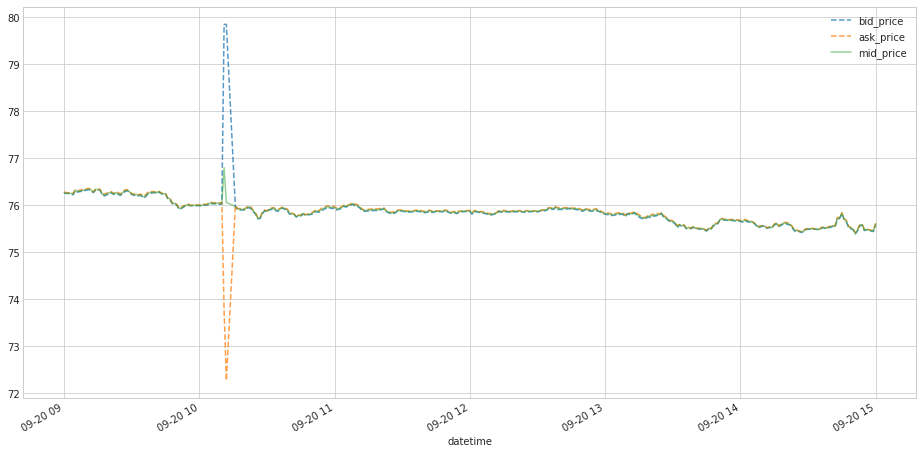

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.5)

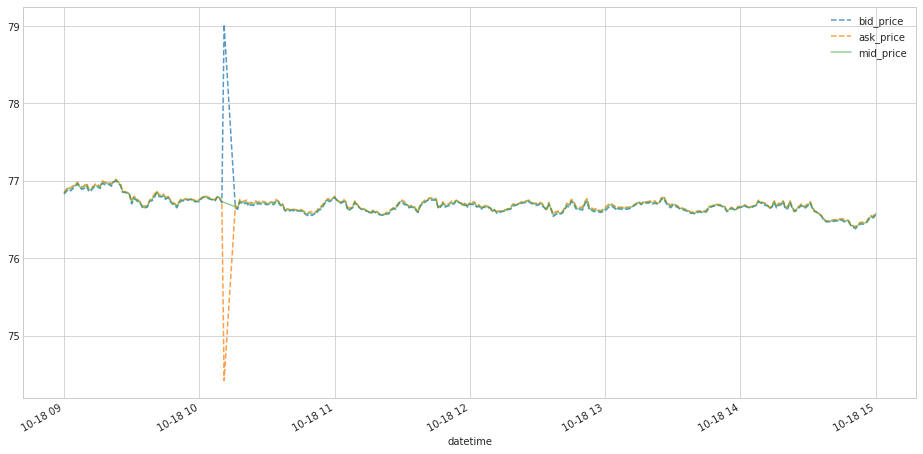

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.5)

### Distributions 

(76.02602175181232, 75.89, 0    74.985
 1    75.990
 dtype: float64)

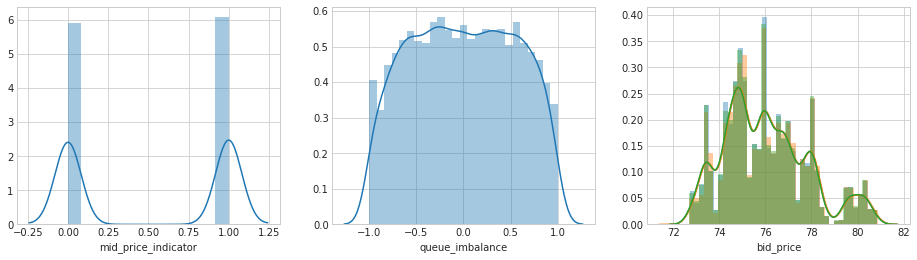

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(df['mid_price_indicator'], ax=ax[0])
sns.distplot(df['queue_imbalance'], ax=ax[1])
sns.distplot(df['mid_price'], ax=ax[2])
sns.distplot(df['ask_price'], ax=ax[2])
sns.distplot(df['bid_price'], ax=ax[2])
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

Distribution of Mid-Price Indidcator is balanced (classes are balanced). Mid-Price distribution is slightly Right-Skewed.

(76.02602175181232, 75.89, 0    74.985
 1    75.990
 dtype: float64)

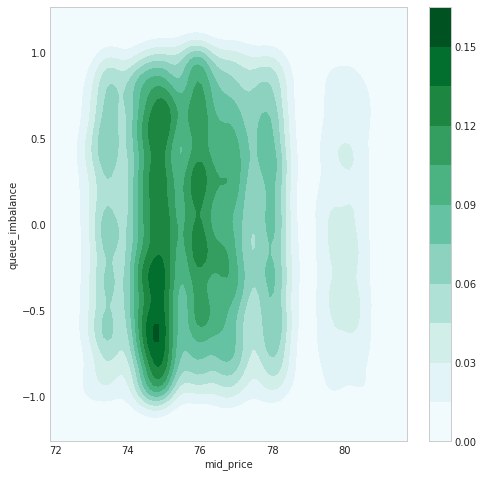

In [9]:
plt.figure(figsize=(8, 8))
sns.kdeplot(df['mid_price'], df['queue_imbalance'], cbar=True, shade=True)
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

We can see that for queue imbalance -1 or 1 the density is the smallest. The highest density for queue imbalance in between -0.5 and 0.5 which happens to be around the mean mid price

### Correlations

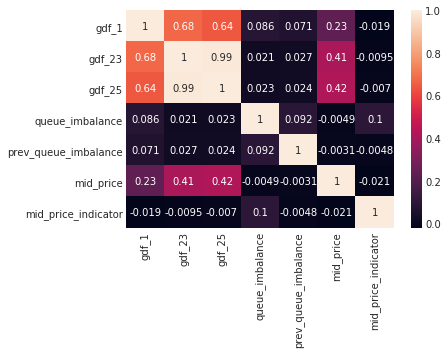

In [10]:
cols = ['gdf_1', 'gdf_23', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance', 
        'mid_price', 'mid_price_indicator']
sns.heatmap(df[cols].corr(), annot=True)
# TODO: ?

In [11]:
### GDF

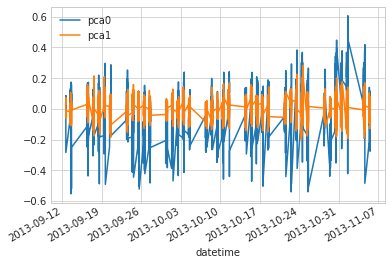

In [12]:
n_components = 2
pca = PCA(n_components=n_components)
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]
p = pca.fit_transform(df[gdf_columns])

for i in range(n_components):
    df['pca' + str(i)] = p[:, i]
pca_cols = ['pca' + str(i) for i in range(n_components)]

cols = ['gdf_23', 'gdf_25', 'queue_imbalance',
        'mid_price', 'mid_price_indicator']
df[pca_cols].plot()

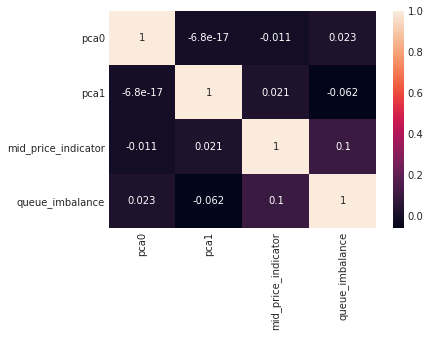

In [13]:

sns.heatmap(df[pca_cols + ['mid_price_indicator', 'queue_imbalance']].corr(), annot=True)

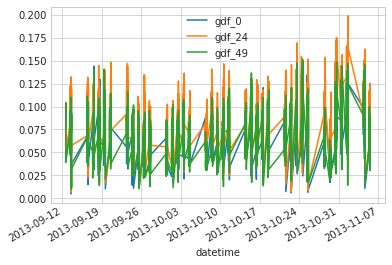

In [14]:
df[['gdf_0', 'gdf_24', 'gdf_49']].plot()

Text(0.5,1,'0.0')

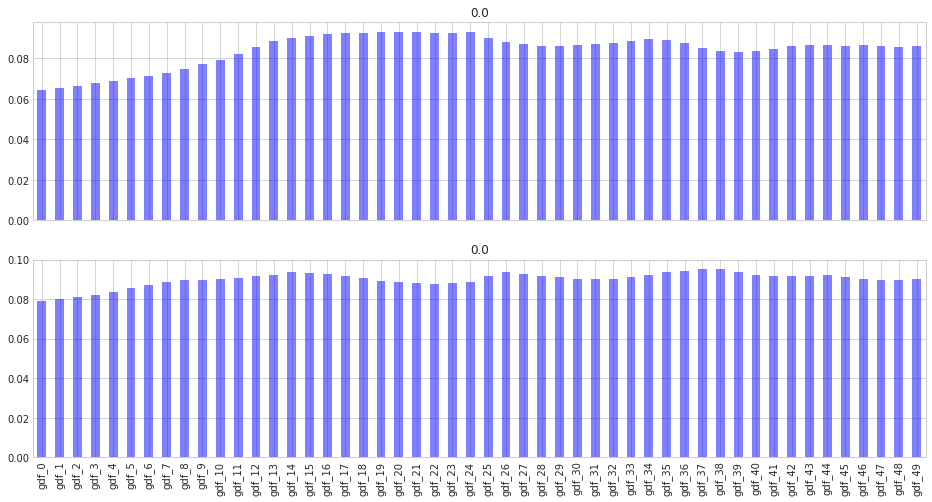

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[gdf_columns].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[gdf_columns].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

Text(0.5,1,'0.0')

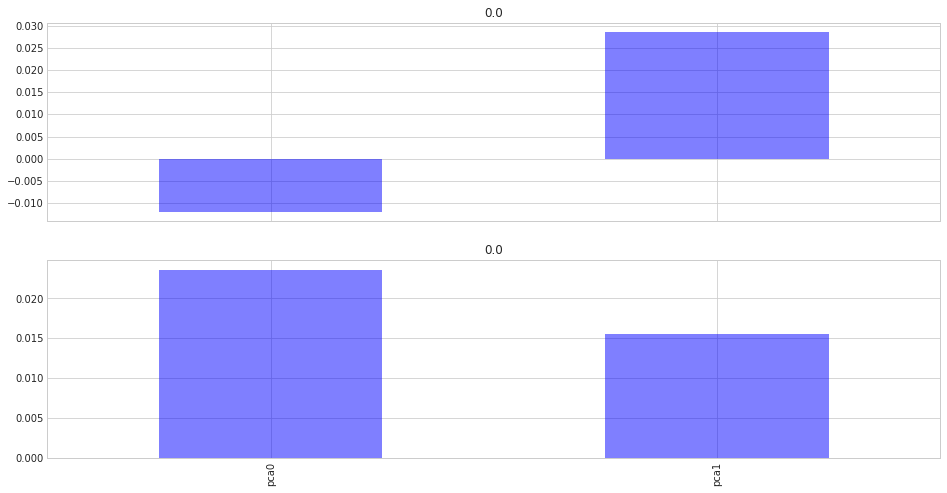

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[pca_cols].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[pca_cols].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

In [17]:
df.head()

,Unnamed: 0,gdf_0,gdf_1,gdf_10,gdf_11,gdf_12,gdf_13,gdf_14,gdf_15,gdf_16,...,gdf_9,mid_price,mid_price_indicator,datetime,bid_price,ask_price,queue_imbalance,prev_queue_imbalance,pca0,pca1
datetime,,,,,,,,,,,,,,,,,,,,,
2013-09-12 14:42:00,3001,0.064537,0.065262,0.079496,0.082221,0.085585,0.088581,0.090186,0.091120,0.092286,...,0.077145,75.510,0.0,2013-09-12 14:42:00,75.49,75.53,-0.750835,-0.383623,-0.012009,0.028560
2013-09-12 14:43:00,3002,0.067212,0.067827,0.083826,0.087539,0.090337,0.093438,0.095575,0.097320,0.098497,...,0.080471,75.505,1.0,2013-09-12 14:43:00,75.49,75.52,-0.021731,-0.750835,0.020215,0.035006
2013-09-12 14:44:00,3003,0.068146,0.071077,0.087577,0.090302,0.093650,0.096161,0.098431,0.100396,0.101838,...,0.085091,75.510,1.0,2013-09-12 14:44:00,75.49,75.53,0.881878,-0.021731,0.029925,0.015244
2013-09-12 14:45:00,3004,0.090087,0.091746,0.088914,0.089031,0.088152,0.087411,0.087095,0.086741,0.086606,...,0.089431,75.615,0.0,2013-09-12 14:45:00,75.60,75.63,-0.484664,0.881878,0.038072,0.006377
2013-09-12 14:46:00,3005,0.078952,0.079602,0.089263,0.090763,0.091573,0.091193,0.089679,0.088365,0.087200,...,0.087663,75.570,1.0,2013-09-12 14:46:00,75.55,75.59,0.739090,-0.484664,0.000568,0.017206


Text(0,0.5,'')

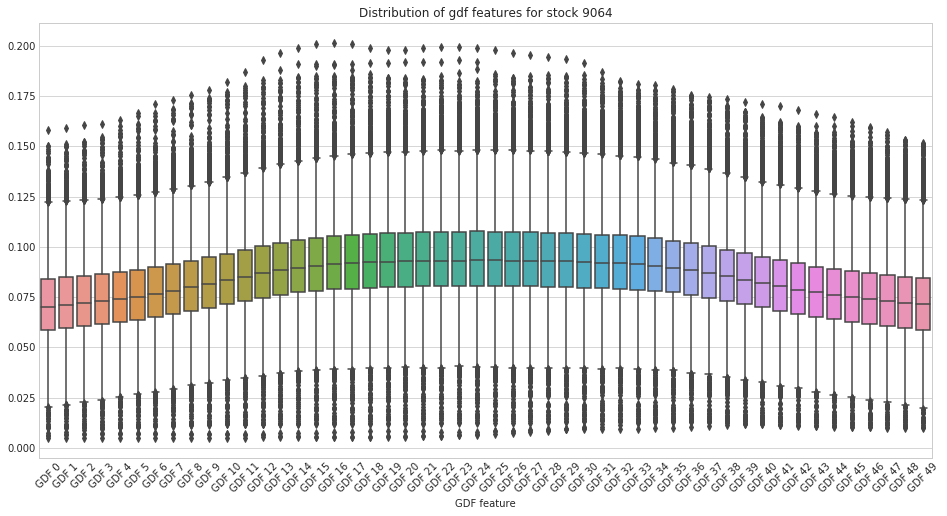

In [18]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[gdf_columns])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in gdf_columns], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

Text(0,0.5,'')

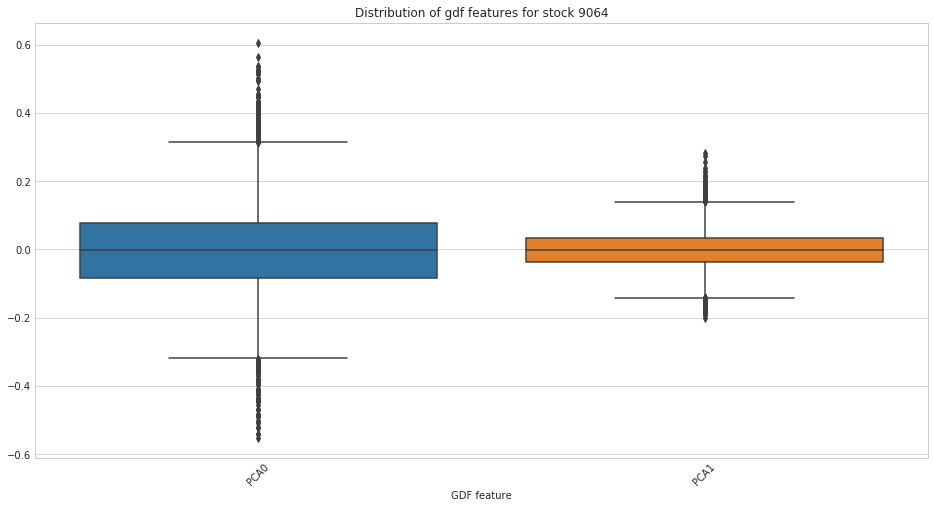

In [19]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[pca_cols])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in pca_cols], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

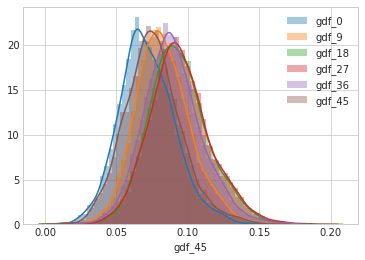

In [20]:
for g in gdf_columns[::9]:
    sns.distplot(df[g], label=g)
plt.legend()

## Predictions

In [21]:
def get_kernel_from_method(method):
    return method.split('_')[1]

class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df, should_validate=False, method=None):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=should_validate)
        else:
            res = gdf_df.train_clf(self.clf, self.feature_name, should_validate=should_validate)
            if method:
                res['kernel'] = method
            return res

### Queue Imbalance - LOGIT, SVM (linear, rbf, sigmoid)

In [22]:
def get_best_svm_results_for_queue_imbalance(s, features):
    df_res = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res= df_res[df_res['features'] == features]
    df_res= df_res[df_res['method'] != 'logistic']
    df_res['stock'] = [s for i in range(len(df_res))]
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res.iterrows():
            from ast import literal_eval
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[c] = cc

    return df_res.sort_values(by='matthews', ascending=False).groupby('method').head(1)

In [23]:
df_best_svm_que = get_best_svm_results_for_queue_imbalance(stock, features='queue_imbalance')

In [24]:
log_que_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que', is_svm=False),
]

svm_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que') 
                for i, row in df_best_svm_que.iterrows()]


In [25]:
res = []
for clf in log_que_clfs + svm_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que = pd.DataFrame(res)
df_res_que

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que,NaN,logistic,9064,0.579029,0.090139,0.090806,0.548330,0.613368,0.544973,0.561199,0.081829,0.081998,0.544484,0.578973,0.540880
1,1.00,1.0,que,0.1,sigmoid,9064,0.527442,0.088410,0.088884,0.557257,0.500655,0.544286,0.528819,0.089358,0.089734,0.555073,0.504936,0.544733
2,0.01,NaN,que,1000.0,rbf,9064,0.674475,0.000000,0.000000,0.508836,1.000000,0.500000,0.672457,0.000000,0.000000,0.506542,1.000000,0.500000
3,0.10,NaN,que,NaN,linear,9064,0.566794,0.090427,0.090598,0.550680,0.583879,0.545164,0.550061,0.079027,0.079042,0.544780,0.555446,0.539503


### Queue Imbalance and Prev Queue Imbalance

In [26]:
df_best_svm_prev_que = get_best_svm_results_for_queue_imbalance(
    stock, features='queue_imbalance, prev_queue_imbalance')

In [27]:
prev_que_log_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que_prev', is_svm=False),
]

svm_prev_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que_prev') 
                for i, row in df_best_svm_prev_que.iterrows()]

In [28]:
res = []
for clf in prev_que_log_clfs + svm_prev_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que_prev = pd.DataFrame(res)
df_res_que_prev

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que_prev,NaN,logistic,9064,0.574741,0.093263,0.093668,0.550751,0.600917,0.546555,0.561303,0.083023,0.083183,0.545116,0.578480,0.541478
1,10.0,NaN,que_prev,0.10,rbf,9064,0.564593,0.088520,0.088657,0.550031,0.579948,0.544217,0.554779,0.086473,0.086499,0.548185,0.561533,0.543222
2,100.0,0.1,que_prev,0.01,sigmoid,9064,0.589474,0.086472,0.087952,0.544747,0.642202,0.543097,0.580360,0.080508,0.081563,0.540779,0.626193,0.540170
3,100.0,NaN,que_prev,NaN,linear,9064,0.565231,0.089856,0.089994,0.550653,0.580603,0.544884,0.552280,0.083185,0.083203,0.546759,0.557914,0.541581


### GDF Plain

In [29]:
df_gdf_plain_res = pd.DataFrame()
gdf_results_dir = '../gaussian_filter/data_res_9061_len15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_plain_res = df_gdf_plain_res.append(temp_df)
print(df_gdf_plain_res.columns)
df_gdf_plain_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(1)

Index([], dtype='object')


KeyError: 'matthews'

In [ ]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0]
hidden_layer_sizes = [(14, 6)]

res = []

for hidden_layer_size in hidden_layer_sizes:
    for alpha in alphas:
        solver = 'adam'
        activation = 'tanh'
        clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                            hidden_layer_sizes=hidden_layer_size, random_state=1)

        c = CFR(clf=clf, feature_name='gdf_0_50', is_svm=False)
        r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
        res.append({**r, 'hidden_layer_size': hidden_layer_size, 
                    'alpha': alpha, 'activation': activation, 'solver': solver})
df_res1 = pd.DataFrame(res).sort_values(by='matthews', ascending=False)

### GDF with PCA

In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca_gdf3_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca1_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [ ]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca2_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

In [ ]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0]
hidden_layer_sizes = [(14, 6)]

res = []

for hidden_layer_size in hidden_layer_sizes:
    for alpha in alphas:
        solver = 'adam'
        activation = 'tanh'
        clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                            hidden_layer_sizes=hidden_layer_size, random_state=1)

        c = CFR(clf=clf, feature_name='pca_gdf_que_prev10', is_svm=False)
        r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
        res.append({**r, 'hidden_layer_size': hidden_layer_size, 
                    'alpha': alpha, 'activation': activation, 'solver': solver})
df_res = pd.DataFrame(res).sort_values(by='matthews', ascending=False)

In [ ]:
df_res.head()

In [30]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0]
learning_rates = [0.000001, 0.00001, 0.001, 0.1, 1.0]
hidden_layer_sizes = [(14, 6)]

res = []
for i in range(len(gdf_dfs)):
    for learning_rate in learning_rates:
        for alpha in alphas:
            hidden_layer_size = (14, 6)
            solver = 'adam'
            activation = 'tanh'
            clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation, 
                                learning_rate_init=learning_rate,
                                hidden_layer_sizes=hidden_layer_size, random_state=1)

            c = CFR(clf=clf, feature_name='pca_gdf_que_prev10', is_svm=False)
            r = c.get_result(gdf_dfs[i], should_validate=True, method='mlp')
            res.append({**r, 'hidden_layer_size': hidden_layer_size, 'gdf_dfs': i, 
                        'alpha': alpha, 'activation': activation, 'solver': solver, 
                        'learning_rate': learning_rate})
df_res = pd.DataFrame(res).sort_values(by='matthews', ascending=False)